In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

class SRResBlock(torch.nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(SRResBlock, self).__init__()

        self.sub_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same', stride=1),
            torch.nn.BatchNorm2d(channels),
            torch.nn.PReLU()
        )

        self.sub_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels, kernel_size=kernel_size, padding='same', stride=1),
            torch.nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        residual = x
        x = self.sub_block1(x)
        x = self.sub_block2(x)

        return x + residual

class SRUpsampleBlock(torch.nn.Module):
    def __init__(self, channels, scale=2):
        super(SRUpsampleBlock, self).__init__()

        self.upsample = torch.nn.Sequential(
            torch.nn.Conv2d(channels, channels * (scale ** 2), kernel_size=3, padding='same', stride=1),
            torch.nn.PixelShuffle(scale),
            torch.nn.PReLU()
        )

    def forward(self, x):
        return self.upsample(x)
        
class SRResNet(torch.nn.Module):
    def __init__(self, in_out_channels=3, hidden_channel=64, kernel_sizes=(9, 3, 9), scale=4):
        super(SRResNet, self).__init__()

        self.block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_out_channels, hidden_channel, kernel_size=kernel_sizes[0], padding='same', stride=1),
            torch.nn.PReLU()
        )

        self.residual_blocks = torch.nn.Sequential(
            *[SRResBlock(channels=hidden_channel, kernel_size=kernel_sizes[1]) for _ in range(16)]
        )

        self.block2 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_channel, hidden_channel, kernel_size=kernel_sizes[1], padding='same', stride=1),
            torch.nn.BatchNorm2d(hidden_channel)
        )

        # Assuming scale of power of 2
        self.upsample_blocks = torch.nn.Sequential(
            *[SRUpsampleBlock(channels=hidden_channel, scale=2) for _ in range(int(np.log2(scale)))]
        )

        self.block3 = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_channel, in_out_channels, kernel_size=kernel_sizes[2], padding='same', stride=1)
        )

    def forward(self, x):
        x = self.block1(x)

        residual = x

        x = self.residual_blocks(x)
        x = self.block2(x)

        x += residual

        x = self.upsample_blocks(x)
        x = self.block3(x)

        x = x.clamp(-1.0, 1.0)  # Ensure output is in [-1, 1] range

        return x
    
class SRGANTrainingDataset(Dataset):
    def __init__(self, img_dir, sub_img_size=96, scale=4, subset=None, cache_size=256):
        super(SRGANTrainingDataset, self).__init__()

        self.img_dir = img_dir
        self.sub_img_size = sub_img_size
        self.scale = scale
        self.cache_size = cache_size
        self.cache = OrderedDict()

        self.crop = transforms.RandomCrop(sub_img_size)

        if subset is None:
            self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)]
        elif isinstance(subset, int):
            self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)[:subset]]
        elif isinstance(subset, float):
            self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)[:int(len(os.listdir(img_dir)) * subset)]]

        self.transform_hr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.transform_lr = transforms.Compose([
            transforms.Resize((sub_img_size // scale, sub_img_size // scale), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if idx in self.cache:
            img = self.cache[idx]
        else:
            img = Image.open(self.img_paths[idx]).convert('RGB')

            if len(self.cache) >= self.cache_size:
                self.cache.popitem(last=False)

            self.cache[idx] = img
        
        sub_img = self.crop(img)

        hr = self.transform_hr(sub_img)
        lr = self.transform_lr(sub_img)

        return lr, hr

class SRGANValidationDataset(Dataset):
    def __init__(self, img_dir, scale=4):
        super(SRGANValidationDataset, self).__init__()

        self.img_dir = img_dir
        self.scale = scale

        self.img_paths = [os.path.join(img_dir, path) for path in os.listdir(img_dir)]

        self.transform_hr = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('RGB')

        w, h = img.size

        transform_lr = transforms.Compose([
            transforms.Resize((h // self.scale, w // self.scale), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor()
        ])

        hr = self.transform_hr(img)
        lr = transform_lr(img)

        return lr, hr

In [32]:
cuda_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

srresnet_x4 = SRResNet().to(cuda_device)

state_dict = torch.load(r'../models/srresnet_x4/srresnet_x4_epoch_6400.pt', weights_only=False)
srresnet_x4.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

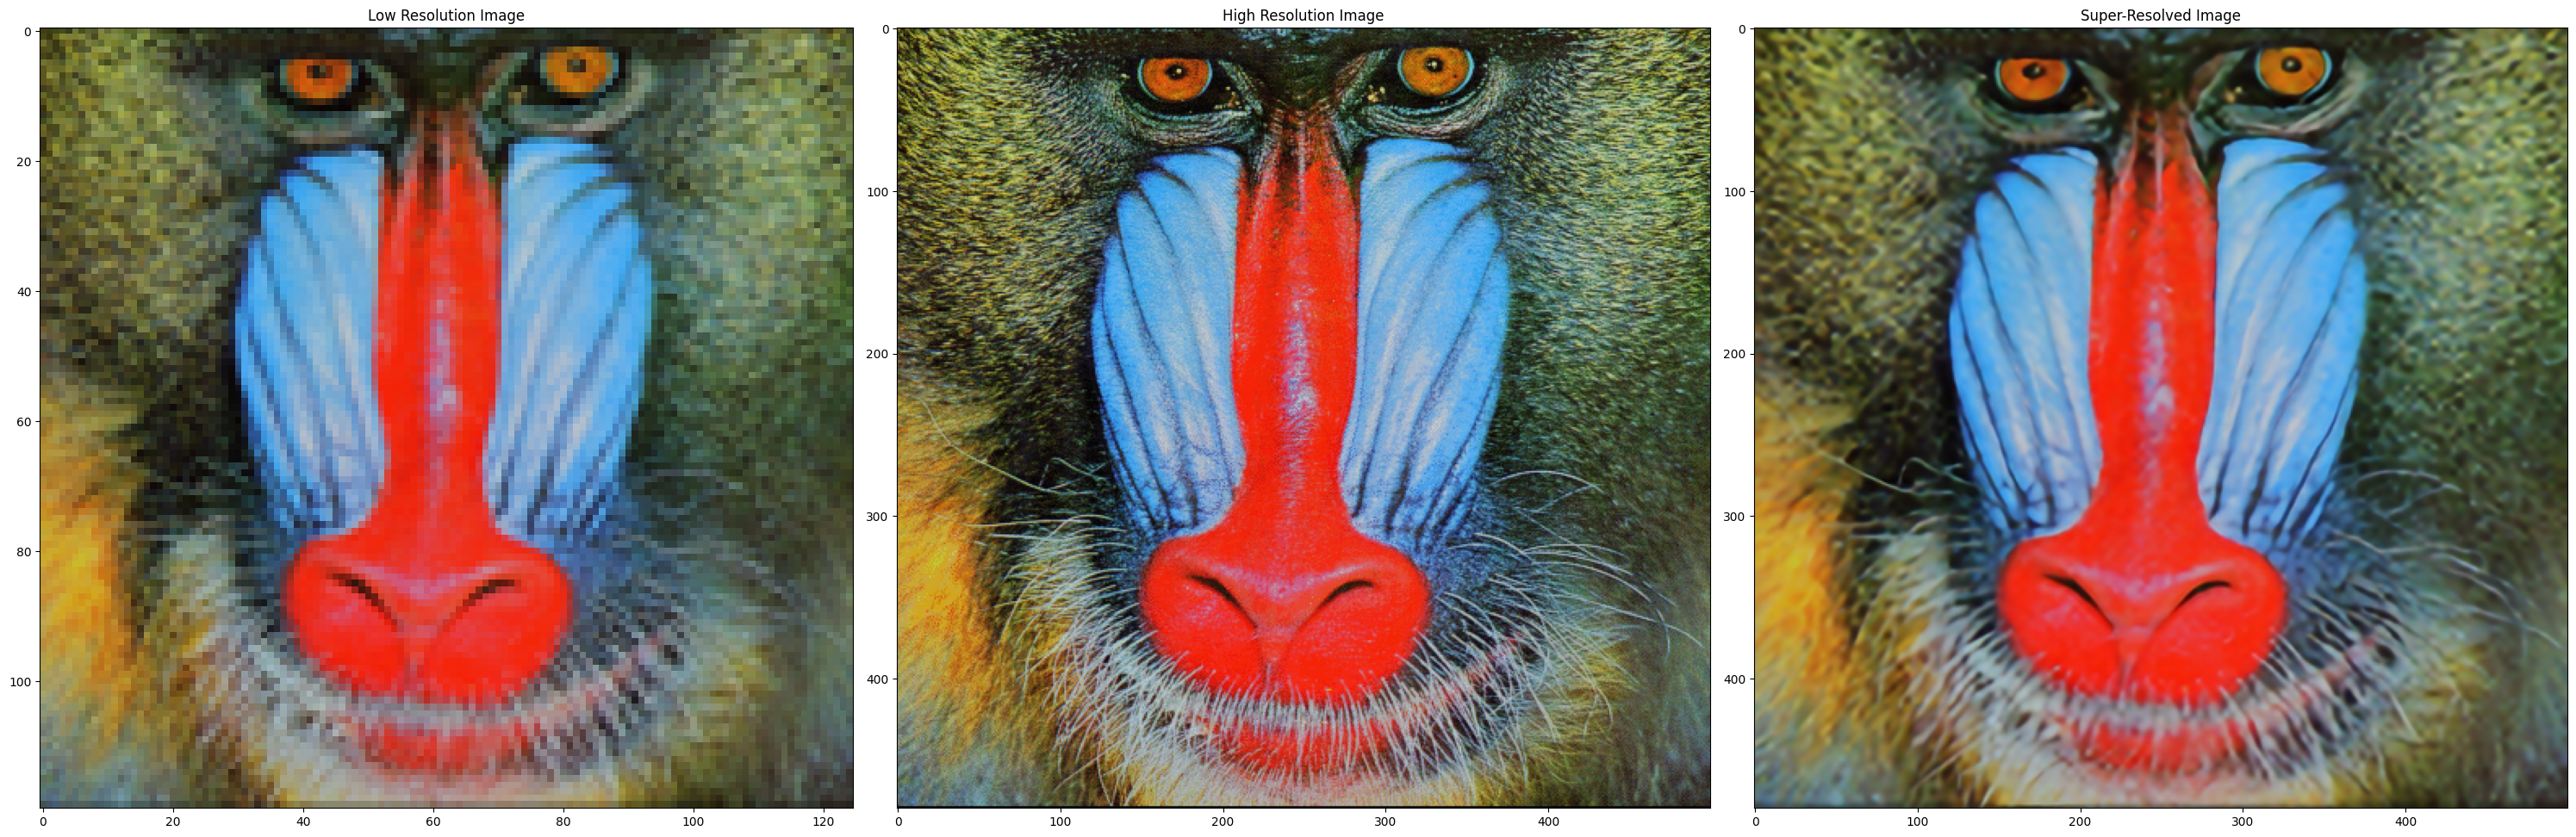

np.float64(20.825065004449343)

In [34]:
set14_dataset = SRGANValidationDataset(
    img_dir=r'../data/Set14',
    scale=4
)

idx = np.random.randint(0,len(set14_dataset))
idx=0
sample_lr, sample_hr = set14_dataset[idx]

srresnet_x4.eval()
with torch.no_grad():
    sr = srresnet_x4(sample_lr.to(cuda_device).unsqueeze(0)).squeeze(0).cpu()

fig, axes = plt.subplots(1, 3, figsize=(30, 15))

sample_hr = sample_hr[
    :,
    :sr.shape[1],
    :sr.shape[2]
]

axes[0].imshow(sample_lr.permute(1, 2, 0).numpy())
axes[0].set_title('Low Resolution Image')
axes[1].imshow((sample_hr * 0.5 + 0.5).permute(1, 2, 0).numpy())
axes[1].set_title('High Resolution Image')
axes[2].imshow((sr * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy())
axes[2].set_title('Super-Resolved Image')

plt.tight_layout()
plt.show()

psnr((sample_hr * 0.5 + 0.5).permute(1, 2, 0).numpy(), (sr * 0.5 + 0.5).permute(1, 2, 0).numpy(), data_range=1.0)

In [12]:
sr_psnrs = []

for i, (lr, hr) in enumerate(set14_dataset):
    srresnet_x4.eval()

    with torch.no_grad():
        sr = srresnet_x4(lr.to(cuda_device).unsqueeze(0)).squeeze(0).cpu()

    hr = hr[
        :,
        :hr.shape[1] // 4 * 4,
        :hr.shape[2] // 4 * 4
    ]

    sr_psnr = psnr((hr * 0.5 + 0.5).permute(1, 2, 0).numpy(), (sr * 0.5 + 0.5).permute(1, 2, 0).numpy(), data_range=1.0)

    sr_psnrs.append(sr_psnr)

print(f'Average PSNR for Super-Resolved Images: {np.mean(sr_psnrs):.2f} dB')
print('-' * 100)
print(f'Maximum PSNR for Super-Resolved Images: {np.max(sr_psnrs):.2f} dB')
print('-' * 100)
print(f'Minimum PSNR for Super-Resolved Images: {np.min(sr_psnrs):.2f} dB')

Average PSNR for Super-Resolved Images: 25.27 dB
----------------------------------------------------------------------------------------------------
Maximum PSNR for Super-Resolved Images: 30.78 dB
----------------------------------------------------------------------------------------------------
Minimum PSNR for Super-Resolved Images: 18.90 dB


In [13]:
sr_psnrs

[np.float64(20.8158367596876),
 np.float64(24.471564364375517),
 np.float64(23.92681791014667),
 np.float64(24.87609241254753),
 np.float64(19.221588967220285),
 np.float64(29.840891301569833),
 np.float64(23.48879475340646),
 np.float64(29.686474109414156),
 np.float64(30.310487283498553),
 np.float64(26.033141342793833),
 np.float64(30.783501341292162),
 np.float64(29.350600858438284),
 np.float64(22.117661463814787),
 np.float64(18.89656320660057)]